**NOTEBOOK ON BERT CLASSIFIER + LGBM CLASSIFIER**

This notebook is to see if a bert classifier help us to clean the data for a better classification  of polairzation.
You will likely need to install these libraries first.
In your terminal or a new notebook cell, run:
!pip install transformers
!pip install torch

**BERT**

BERT stands for: "Bidirectional encoder representations from transformers (BERT)", and basically is a Language Model with self-supervised learning. This will aloow us to wrok the Natural Language Processing (NLP) of our databae composed of tweets,ad processe them as vectors. This step will allos us not ontluy to manage in more interpetable way the text for an algorithm to work, but also to reduce the ambiguity for the algorithm. For BERT we are going to use a distilled version distilBERT.

"Fundamentally, BERT is a stack of Transformer encoder layers (Vaswani et al., 2017) which consist
of multiple self-attention "heads". For every input token in a sequence, each head computes key, value
and query vectors, used to create a weighted representation. The outputs of all heads in the same layer
are combined and run through a fully-connected layer. Each layer is wrapped with a skip connection
and followed by layer normalization.
The conventional workflow for BERT consists of two stages: pre-training and fine-tuning. Pre-
training uses two self-supervised tasks: masked language modeling (MLM, prediction of randomly
masked input tokens) and next sentence prediction (NSP, predicting if two input sentences are adjacent
to each other). In fine-tuning for downstream applications, one or more fully-connected layers are
typically added on top of the final encoder layer.
The input representations are computed as follows: each word in the input is first tokenized into
wordpieces (Wu et al., 2016), and then three embedding layers (token, position, and segment) are
combined to obtain a fixed-length vector. Special token [CLS] is used for classification predictions,
and [SEP] separates input segments." - Rogers et al, 2020.

**LGBM**

Light GBM stands for "Light Gradient-Boosting Machine". Is a framework developed for microsoft to wrok with decistion tree algorithms. For algorithm, after try different set of algorithms, we are goping to use LGBM classifier. The abasic strucutre of a tree algorithm is a tree data structure. This are hierarchical and composed of nodes connected by edges, each node can have "children" nodes and one "parent" node, except for the root node which has no parent. 



The idea for a larger project would be to validate it with human coders.
Load the small, training-labeled dataset
This file contains the 'polar_score' needed for training.
For this exercise we choose to use GPT capabilities to train the small dataset sample. 
The idea for a larger project would be to validate it with human coders.

**Structure:**

Setup and Imports: Imports libraries including torch, transformers (for DistilBertModel and tokenizer), lightgbm, and joblib for model saving.

Data: The GPT-4 labeled data is loaded. A function, get_polarization_level, is defined to map the numerical polar_score into four distinct categories: None, Low, Medium, and High. This was made in this way beacuse in the normal scores we have some codes GPT didn't fill like -4,and some others were there were too few to work adequately in a training model. The data is split into training and testing sets based on this new 4-level target variable.

BERT embedding generation: The pre-trained distilbert-base-uncased model and tokenizer are loaded. A get_bert_embeddings function is defined to process the santext column. It tokenizes the text and passes it through the BERT model to generate a 768-dimensional vector embedding for each tweet. This captures the semantic meaning of the text and since is vectorized it will help to reduce noise and give more clarity to the classifier. The nadi side of this apporach is that it require more computer power, so it is recommended to do it in the local hotspot of Anaconda or Gogle COLAB. In the case of this exercise was made in the local hotspot online of Anaconda and when try to work on the LAB the time and computer consumptios was noticeable slower.

Model training and evaluation: An initial LogisticRegression model is trained on the BERT embeddings as a benchmark. The main LightGBM Classifier (LGBMClassifier) is trained using the BERT embeddings as input features. The model's performance is evaluated using a classification_report and a confusion matrix, showing its accuracy on the 4-level classification task.

Production and saving: The trained LGBMClassifier is saved as the final "champion model" to a .pkl file using joblib. The final section of the notebook details the "production" process, where the large, unlabeled dataset is loaded in chunks. For each chunk, BERT embeddings are generated, and the saved champion model is used to predict the polarization level. The processed chunks are saved and later merged into a final, fully classified dataset.


**References**

Reference for Bert
@article{devlin2018bert,
  title={BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding},
  author={Devlin, Jacob and Chang, Ming-Wei and Lee, Kenton and Toutanova, Kristina},
  journal={arXiv preprint arXiv:1810.04805},
  year={2018}
}

@misc{rogers2020primerbertologyknowbert,
      title={A Primer in BERTology: What we know about how BERT works}, 
      author={Anna Rogers and Olga Kovaleva and Anna Rumshisky},
      year={2020},
      eprint={2002.12327},
      archivePrefix={arXiv},
      primaryClass={cs.CL},
      url={https://arxiv.org/abs/2002.12327}, 
}

Reference for LGBM
Yu Shi, Guolin Ke, Zhuoming Chen, Shuxin Zheng, Tie-Yan Liu. "Quantized Training of Gradient Boosting Decision Trees" (link). Advances in Neural Information Processing Systems 35 (NeurIPS 2022), pp. 18822-18833.

Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, Tie-Yan Liu. "LightGBM: A Highly Efficient Gradient Boosting Decision Tree". Advances in Neural Information Processing Systems 30 (NIPS 2017), pp. 3149-3157.

Qi Meng, Guolin Ke, Taifeng Wang, Wei Chen, Qiwei Ye, Zhi-Ming Ma, Tie-Yan Liu. "A Communication-Efficient Parallel Algorithm for Decision Tree". Advances in Neural Information Processing Systems 29 (NIPS 2016), pp. 1279-1287.

Huan Zhang, Si Si and Cho-Jui Hsieh. "GPU Acceleration for Large-scale Tree Boosting". SysML Conference, 2018.



**MODEL 6: BERT + LightGBM evaluation**

**MODEL 6: BERT + LightGBM EVALUATION**

This part of the code is just to load the data and evaluate the statistics of the combination of the prcoes and a generate a complete model. If the statistics are beter than the other models this will be the final (champion) model.

In [1]:
#  libraries

import torch
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
import os
import glob
from tqdm.auto import tqdm
from lightgbm import LGBMClassifier


# We will use the same data splits from our previous experiment
# X_train_level, X_test_level, y_train_level, y_test_level
# and the same category order
# category_order = ['None', 'Low', 'Medium', 'High']

In [2]:
# parte 2 la data
# Load the small, training-labeled dataset
# This file contains the 'polar_score' needed for training.
# For this exercise we choose to use GPT capabilities to train the small dataset sample. 
#The idea for a larger project would be to validate it with human coders.
labeled_filepath = "data/sample/debate_tweets_sample_1000_for_annotation_labeled.csv" #this is the final csv from notebook 2
df_labeled = pd.read_csv(labeled_filepath)


# Clean and Prepare Data
# Filter out invalid scores and convert the column to a numeric type
df_multi = df_labeled[df_labeled['polar_score'] != 'INV'].copy()
df_multi['polar_score'] = pd.to_numeric(df_multi['polar_score'])


# Define the function to create the 4 polarization levels
def get_polarization_level(score):
    score = int(score)
    if score in [-7, -6, 6, 7]:
        return 'High'
    elif score in [-5, -4, 4, 5]:
        return 'Medium'
    elif score in [-3, -2, 2, 3]:
        return 'Low'
    elif score in [-1, 0, 1]:
        return 'None'
    return None # Fallback

# Create the new target column by applying the function
df_multi['polarization_level'] = df_multi['polar_score'].apply(get_polarization_level)


# Create the final training and testing splits with the variables BERT will need.
X_train_level, X_test_level, y_train_level, y_test_level = train_test_split(
    df_multi['santext'].fillna(''),  # Use .fillna('') as a safeguard
    df_multi['polarization_level'],
    test_size=0.2,
    random_state=42,
    stratify=df_multi['polarization_level']
)

# Confirmation Print
print("Data successfully loaded and prepared for the BERT model.")
print(f"Training features (X_train_level) shape: {X_train_level.shape}")
print(f"Testing features (X_test_level) shape: {X_test_level.shape}")
print("\nValue counts in the training labels (y_train_level):")
print(y_train_level.value_counts())

Data successfully loaded and prepared for the BERT model.
Training features (X_train_level) shape: (726,)
Testing features (X_test_level) shape: (182,)

Value counts in the training labels (y_train_level):
polarization_level
Medium    331
Low       301
High       61
None       33
Name: count, dtype: int64


In [3]:
#parte 3 la función
# Load the pre-trained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# This part it depends of the equimpemt with the development of the project.
# This was imnportnat to add since the original project was running on a IOS macbook.
# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

def get_bert_embeddings(texts, batch_size=32):
    
    all_embeddings = []
    print(f"Generating embeddings for {len(texts)} texts...")
    
    # Process texts in batches to manage memory
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        # Tokenize the batch of texts
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Get model outputs
        with torch.no_grad():
            outputs = bert_model(**inputs)
        
        # The embedding for each sentence is the hidden state of the [CLS] token
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(cls_embeddings)
        
        if (i + batch_size) % (batch_size * 5) == 0:
             print(f"  Processed {i + batch_size} / {len(texts)}")

    print("Embedding generation complete.")
    return np.array(all_embeddings)

# Generate embeddings for our training and testing sets
# We convert the pandas Series to a list for processing
X_train_bert = get_bert_embeddings(X_train_level.tolist())
X_test_bert = get_bert_embeddings(X_test_level.tolist())

print(f"\nShape of training features: {X_train_bert.shape}")
print(f"Shape of testing features: {X_test_bert.shape}")

Generating embeddings for 726 texts...
  Processed 160 / 726
  Processed 320 / 726
  Processed 480 / 726
  Processed 640 / 726
Embedding generation complete.
Generating embeddings for 182 texts...
  Processed 160 / 182
Embedding generation complete.

Shape of training features: (726, 768)
Shape of testing features: (182, 768)


Modelo, training and evaluaitng the clasdsifier con bert


 BERT + Logistic Regression Evaluation (Polarization Level) 

              precision    recall  f1-score   support

        None       1.00      0.25      0.40         8
         Low       0.59      0.63      0.61        76
      Medium       0.60      0.63      0.62        83
        High       0.67      0.53      0.59        15

    accuracy                           0.60       182
   macro avg       0.71      0.51      0.55       182
weighted avg       0.62      0.60      0.60       182



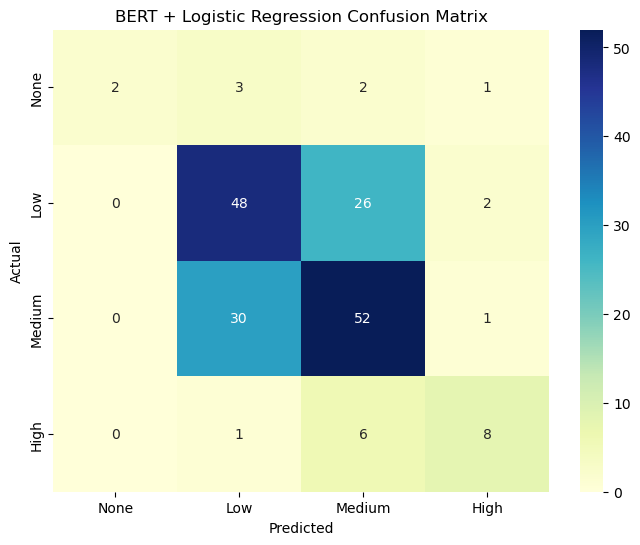

In [4]:
#parte 4 el modelo
# Train the Classifier
# We use a simple Logistic Regression model.
bert_classifier = LogisticRegression(max_iter=1000, random_state=42)
bert_classifier.fit(X_train_bert, y_train_level)

# Make Predictions
y_pred_bert = bert_classifier.predict(X_test_bert)


# Define the order for the report and confusion matrix
category_order = ['None', 'Low', 'Medium', 'High']

# Evaluation
print("\n BERT + Logistic Regression Evaluation (Polarization Level) \n")
print(classification_report(y_test_level, y_pred_bert, labels=category_order))

# Visualize the Confusion Matrix
cm_bert = confusion_matrix(y_test_level, y_pred_bert, labels=category_order)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d',
            xticklabels=category_order, yticklabels=category_order,
            cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT + Logistic Regression Confusion Matrix')
plt.show()

**MODEL 6.: BERT + lightGBM APPLICATION** 

We are going to proceed after vectorization happens with BERT to use the framework fo LGBM to conducnt the classification of the sanitised text. 

In [5]:
#Step 1: prepare the data

# Load the small, human-labeled dataset (in this case and for this project we use only GPT coded training dataset)
labeled_filepath = "data/sample/debate_tweets_sample_1000_for_annotation_labeled.csv"
df_labeled = pd.read_csv(labeled_filepath)

# Clean and prepare the data
df_multi = df_labeled[df_labeled['polar_score'] != 'INV'].copy()
df_multi['polar_score'] = pd.to_numeric(df_multi['polar_score'])

# Define the function to create the 4 polarization levels
# we opt for this path to avoid the problem of not enough data classified in the polar scores.
def get_polarization_level(score):
    score = int(score)
    if score in [-7, -6, 6, 7]: return 'High'
    elif score in [-5, -4, 4, 5]: return 'Medium'
    elif score in [-3, -2, 2, 3]: return 'Low'
    elif score in [-1, 0, 1]: return 'None'
    return None

# Create the new target column
df_multi['polarization_level'] = df_multi['polar_score'].apply(get_polarization_level)

# Create the training and testing splits
X_train_level, X_test_level, y_train_level, y_test_level = train_test_split(
    df_multi['santext'].fillna(''),
    df_multi['polarization_level'],
    test_size=0.2,
    random_state=42,
    stratify=df_multi['polarization_level']
)

print("Step 1 Complete: Data is prepared.")

Step 1 Complete: Data is prepared.


In [1]:
# FINAL MODEL TRAINING AND SAVING
#Step 2: Using BERT features
# You may need to run: pip install transformers torch if it is not installed.


# Load the pre-trained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

def get_bert_embeddings(texts, batch_size=32):
    all_embeddings = []
    print(f"Generating embeddings for {len(texts)} texts...")
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(cls_embeddings)
    print("Embedding generation complete.")
    return np.array(all_embeddings)

# Generate embeddings. This creates the 'X_train_bert' and 'X_test_bert' variables.
X_train_bert = get_bert_embeddings(X_train_level.tolist())
X_test_bert = get_bert_embeddings(X_test_level.tolist())

print("\nStep 2 Complete: BERT features have been created.")
print(f"Shape of training features: {X_train_bert.shape}")


NameError: name 'DistilBertTokenizer' is not defined

In [ ]:
# FINAL MODEL TRAINING AND SAVING

print("Training the champion model (BERT + LightGBM) on the designated training set")

# Initialize a new instance of the champion classifier
champion_classifier = LGBMClassifier(random_state=42)

# Train (fit) the classifier ONLY on the training data embeddings and labels
# X_train_bert was created in the previous step
champion_classifier.fit(X_train_bert, y_train_level)

# filename
CHAMPION_MODEL_FILENAME = 'level_classifier_champion_final.pkl'

# Save the trained classifier to a file using joblib
joblib.dump(champion_classifier, CHAMPION_MODEL_FILENAME)

print(f"\nChampion model trained on {len(X_train_bert)} samples.")
print(f"Model saved successfully as '{CHAMPION_MODEL_FILENAME}'")

In [10]:
#In theory, this will be the line to train the code on the fukll dataset,
#HIOWEVER, try this lines only i your computer run with a large quantity of memory
# Define category order for reports
#category_order = ['None', 'Low', 'Medium', 'High']

# Train the Classifier
#print("\nStep 3: Training LightGBM classifier on BERT features ")
#lgbm_on_bert_classifier = LGBMClassifier(random_state=42)
#lgbm_on_bert_classifier.fit(X_train_bert, y_train_level)

# Make Predictions
#y_pred_lgbm_bert = lgbm_on_bert_classifier.predict(X_test_bert)

# Evaluation
#print("\n BERT Features + LightGBM Evaluation (Polarization Level) \n")
#print(classification_report(y_test_level, y_pred_lgbm_bert, labels=category_order))

# Visualize the Confusion Matrix
#cm_lgbm_bert = confusion_matrix(y_test_level, y_pred_lgbm_bert, labels=category_order)
#plt.figure(figsize=(8, 6))
#sns.heatmap(cm_lgbm_bert, annot=True, fmt='d',
         #   xticklabels=category_order, yticklabels=category_order,
         #   cmap='plasma')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.title('BERT Features + LightGBM Confusion Matrix')
#plt.show()

**FINAL MODEL SAVE BERT * LIGHTBMC**

In [1]:
# PART 8: Production the best Model (BERT + LightGBM). 
# This was the model with a better F after comapring training and validation
# Note: this script was revised, due to the constrictions of the IOS and memory system of the original computer, 
# we need to divide the batch fo analysys due to this constrcitions. 
# If you have a better machine you can run the complete code without dividing it


# Configuration
FULL_DATASET_PATH = 'debate_tweets_classified.csv'
CHAMPION_MODEL_FILENAME = 'level_classifier_champion_final.pkl'
FINAL_OUTPUT_FILENAME = 'debate_tweets_classified_COMPLETE.csv'
NUM_CHUNKS = 16 # Switched to 16 chunks
BERT_BATCH_SIZE = 32
TEMP_CHUNK_DIR = 'temp_chunks'

# BERT Model & Tokenizer Setup 
print("Setting up models ")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
bert_model.to(device)
loaded_champion_classifier = joblib.load(CHAMPION_MODEL_FILENAME) # this was the model who champions all others to maange this task
print(f" Models loaded successfully on device: {device}")

# Embedding Function
def get_bert_embeddings(texts, batch_size=BERT_BATCH_SIZE):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="✨ Generating Embeddings"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(cls_embeddings)
    return np.array(all_embeddings)

# Create Temp Directory & Calculate Chunk Size
os.makedirs(TEMP_CHUNK_DIR, exist_ok=True)
total_rows = sum(1 for row in open(FULL_DATASET_PATH, 'r', encoding='utf-8')) - 1
chunk_size = int(np.ceil(total_rows / NUM_CHUNKS))
# Read header to pass to chunks
header = pd.read_csv(FULL_DATASET_PATH, nrows=0).columns.tolist()

print(f"Total rows: {total_rows}")
print(f"Number of chunks: {NUM_CHUNKS}")
print(f"Rows per chunk: {chunk_size}")
print("\n SETUP COMPLETE. You can now proceed to process the chunks.")

Setting up models 


NameError: name 'torch' is not defined

In [2]:
# Set the index for the chunk you want to process (0 for the first one)
chunk_index = 0

# and the next code wil run the batch in each cell. So we need to copy and paste this model 16 times.
chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f" Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f" Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [3]:
chunk_index = 1

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f" Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"✅ Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [4]:
chunk_index = 2

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [5]:
chunk_index = 3

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [6]:
chunk_index = 4

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [7]:
chunk_index = 5

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [8]:
chunk_index = 6

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f"Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f" Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f" Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [9]:
chunk_index = 7

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [10]:
chunk_index = 8

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [11]:
chunk_index = 9

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f"Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [12]:
chunk_index = 10

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f"Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"✅ Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [13]:
chunk_index = 11

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f" Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f" Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [14]:
chunk_index = 12

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f"Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS}")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [15]:
chunk_index = 13

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f"Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f" Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f" Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [16]:
chunk_index = 14

chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"✅ Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f" An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

In [17]:
chunk_index = 15

# Do not change the code below ---
chunk_output_path = os.path.join(TEMP_CHUNK_DIR, f'chunk_{chunk_index}_complete.csv')
print(f" Preparing to process Chunk {chunk_index + 1} of {NUM_CHUNKS} ")

if os.path.exists(chunk_output_path):
    print(f"Chunk {chunk_index + 1} is already complete. Skipping.")
else:
    try:
        # Calculate how many rows to skip to get to the start of our chunk
        rows_to_skip = 1 + chunk_index * chunk_size # +1 for header
        
        # Read only the specific chunk from the large CSV
        chunk_df = pd.read_csv(
            FULL_DATASET_PATH,
            header=None,
            names=header,
            skiprows=rows_to_skip,
            nrows=chunk_size,
            low_memory=False
        )
        
        # Process the chunk
        chunk_texts = chunk_df['santext'].fillna('').tolist()
        if chunk_texts: # Ensure there are texts to process
            chunk_embeddings = get_bert_embeddings(chunk_texts)
            level_predictions = loaded_champion_classifier.predict(chunk_embeddings)
            chunk_df['predicted_polarization_level'] = level_predictions
            
            # Save the individual processed chunk
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f" Chunk {chunk_index + 1} processed and saved to '{chunk_output_path}'")
        else:
            print(f"No data found for Chunk {chunk_index + 1}. It might be an empty last chunk.")

    except Exception as e:
        print(f"An error occurred while processing Chunk {chunk_index + 1}: {e}")

NameError: name 'os' is not defined

**Combine all the parts**

In [18]:
print("\n Combining all processed chunks into the final file")

# Find all the completed chunk files
chunk_files = sorted(glob.glob(os.path.join(TEMP_CHUNK_DIR, 'chunk_*.csv')))

if len(chunk_files) != NUM_CHUNKS:
    print(f" WARNING: Expected {NUM_CHUNKS} chunk files, but found {len(chunk_files)}.")
    print("Please ensure all chunks were processed before combining.")
else:
    print(f"Found {len(chunk_files)} chunk files. Merging now...")
    
    # Use an iterator and a loop to append chunks
    with open(FINAL_OUTPUT_FILENAME, 'w', encoding='utf-8') as outfile:
        # Write the header using the first file's columns
        pd.read_csv(chunk_files[0], nrows=0).to_csv(outfile, index=False)
        
        # Write data from all chunk files
        for filename in tqdm(chunk_files, desc="Merging Chunks"):
            chunk_data = pd.read_csv(filename)
            chunk_data.to_csv(outfile, mode='a', header=False, index=False)

    print(f"\n All chunks combined into '{FINAL_OUTPUT_FILENAME}'")
    print("You can now safely delete the 'temp_chunks' directory if you wish.")


 Combining all processed chunks into the final file


NameError: name 'glob' is not defined

In [19]:
import pandas as pd
import io

def evaluate_dataframe(filepath):
    
    try:
        print(f"Loading and analyzing '{filepath}'\n")
        # Load the dataset
        df = pd.read_csv(filepath, low_memory=False)

        # File Structure and Shape
        print("File Structure and Shape")
        rows, cols = df.shape
        print(f"Total Rows: {rows}")
        print(f"Total Columns: {cols}\n")

        # Column Analysis 
        print("Column Analysis (Name, Non-Null Count, Dtype)")
        # .info() provides a concise summary of the DataFrame
        # We capture its output to print it directly.
        buffer = io.StringIO()
        df.info(buf=buffer)
        info_str = buffer.getvalue()
        print(info_str)

        # Data Sample
        print("\nData Sample")
        # Display a sample with key columns for a quick look at the content
        sample_cols = [
            'tweet_id', 'author_id', 'created_at', 'text', 'santext',
            'predicted_polarization_level'
        ]
        # Ensure the columns exist before trying to display them
        display_cols = [col for col in sample_cols if col in df.columns]
        print(df[display_cols].head())

    except FileNotFoundError:
        print(f"Error: The file was not found at the path: {filepath}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Run the Evaluation ---
# Replace with the actual path to your file if it's in a different directory
file_to_evaluate = 'debate_tweets_classified_COMPLETE.csv'
evaluate_dataframe(file_to_evaluate)

Loading and analyzing 'debate_tweets_classified_COMPLETE.csv'



KeyboardInterrupt: 

In [ ]:
def evaluate_dataframe(filepath):
   
    try:
        print(f"Loading and analyzing '{filepath}'\n")
        # Load the dataset
        df = pd.read_csv(filepath, low_memory=False)

        # File Structure and Shape
        print("File Structure and Shape")
        rows, cols = df.shape
        print(f"Total Rows: {rows}")
        print(f"Total Columns: {cols}\n")

        # Column Analysis
        print("Column Analysis (Name, Non-Null Count, Dtype)")
        # .info() provides a concise summary of the DataFrame
        # We capture its output to print it directly.
        buffer = io.StringIO()
        df.info(buf=buffer)
        info_str = buffer.getvalue()
        print(info_str)

        # Data Sample
        print("\nData Sample")
        # Display a sample with key columns for a quick look at the content
        sample_cols = [
            'tweet_id', 'author_id', 'created_at', 'text', 'santext',
            'predicted_polarization_level'
        ]
        # Ensure the columns exist before trying to display them
        display_cols = [col for col in sample_cols if col in df.columns]
        print(df[display_cols].head())

    except FileNotFoundError:
        print(f"Error: The file was not found at the path: {filepath}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Run the Evaluation ---
# Replace with the actual path to your file if it's in a different directory
file_to_evaluate = 'data/processed/debate_tweets_with_polarization_and_sentiment.csv'
evaluate_dataframe(file_to_evaluate)

In [ ]:
!ls -lhra

In [ ]:
%%writefile .gitignore
secrets.json